# (Dataset Exploration Title)
## by Andrew Shannon

Churn analysis
https://www.charlesbordet.com/en/how-to-predict-ltv-saas-startup/#

## Preliminary Wrangling

> Briefly introduce your dataset here.

In [33]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.style.use('fivethirtyeight')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

> Load in your dataset and describe its properties through the questions below.
Try and motivate your exploration goals through this section.

In [53]:
df = pd.read_csv("telco_customer_churn.csv")
df = df[df['tenure'] != 0]

In [54]:
# High level overview of data

print(df.shape)
print(df.dtypes)

(7032, 21)
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


In [57]:
df = df.replace({'No phone service': 'No', 'No internet service': 'No', r'\s+': 'trash'}, regex=True)
df['SeniorCitizen'] = df.SeniorCitizen.replace({0: 'No', 1: 'Yes'})
df['TotalCharges'] = df.TotalCharges.astype('float')

In [58]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,No,Yes,No,1,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,No,No,No,45,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [172]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'], dtype='object')

In [59]:
df.InternetService.value_counts()

Fiber optic    3096
DSL            2416
No             1520
Name: InternetService, dtype: int64

In [72]:
contracts = ['Month-to-month', 'One year', 'Two year']

ordered_contracts = pd.api.types.CategoricalDtype(ordered=True, categories=contracts)
df['Contract'] = df.Contract.astype(ordered_contracts)

In [73]:
df.Contract.value_counts()

Month-to-month    3875
Two year          1685
One year          1472
Name: Contract, dtype: int64

In [74]:
df.PaymentMethod.value_counts()

Electronic check             2365
Mailed check                 1604
Bank transfer (automatic)    1542
Credit card (automatic)      1521
Name: PaymentMethod, dtype: int64

### What is the structure of your dataset?

> There are 7032 rows with 21 variables.  The majority of the variables are boolean yes / no.  Senior citizen was inconsistently coded as 1 / 0 in comparison to the other variables that were yes / no.  Aside from gender there are three categorical variables InternetService [Fiber optic, DSL, No], Contract [Month to Month, Two year, One year], and PaymentMethod [Electronic check, Mailed check, Bank transfer (auto), Credit card (auto)].  

> Contract by duration [Month to Month, One year, Two year]

### What is/are the main feature(s) of interest in your dataset?

> I am most interested in identifying which features are best for predicting long tenure.

> I am secondly interested in identifying which features are best for predicting churn.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> I think that for both predictions above, contract will be the most important factor, and maybe also the number of services, and bill size.

## Univariate Exploration

> In this section, investigate distributions of individual variables. If
you see unusual points or outliers, take a deeper look to clean things up
and prepare yourself to look at relationships between variables.

First, I will look at the distribution of TotalCharges.

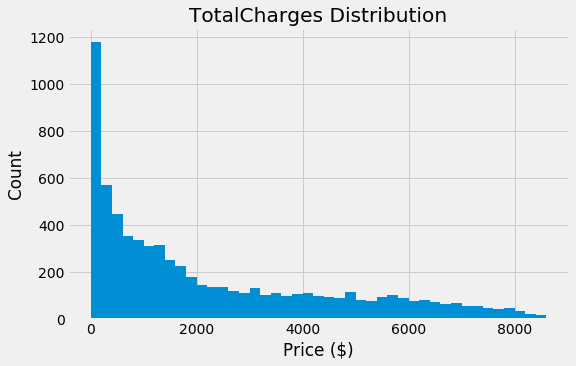

In [95]:
bins = np.arange(0, df['TotalCharges'].max(), 200)

plt.figure(figsize=[8, 5])
plt.hist(data=df, x='TotalCharges', bins=bins)

plt.xlabel('Price ($)')
plt.ylabel('Count')

plt.title('TotalCharges Distribution');

<h3> Since there is a very long tail with the majority of TotalCharges under $2000, I will perform a log transformation on the X axis. </h3>

In [130]:
np.log(df['TotalCharges'].describe())

count    8.858226
mean     7.733377
std      7.726112
min      2.933857
25%      5.995083
50%      7.242422
75%      8.241371
max      9.069330
Name: TotalCharges, dtype: float64

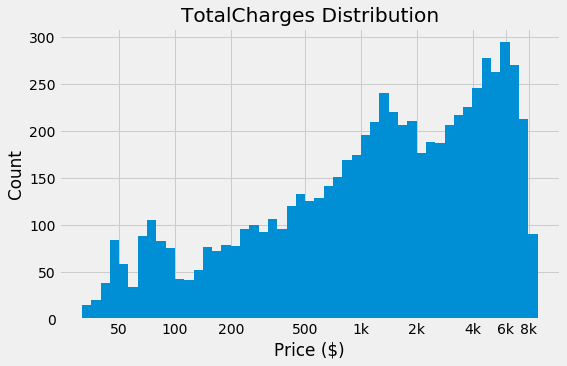

In [155]:
log_binsize = 0.05
bins = 10 ** np.arange(1.5, np.log10(df['TotalCharges'].max())+log_binsize, log_binsize)

plt.figure(figsize=[8, 5])
plt.hist(data=df, x='TotalCharges', bins=bins)

plt.xlabel('Price ($)')
plt.xscale('log')
plt.xticks([5e1, 1e2, 2e2, 5e2, 1e3, 2e3, 4e3, 6e3, 8e3], ['50', '100', '200', '500', '1k', '2k', '4k', '6k', '8k'])

plt.ylabel('Count')

plt.title('TotalCharges Distribution');

> TotalCharges distribution indicates that the majority of customers have spent less than 2000. When plotted on a log scale, the distirbution is bimodal.  The first peak is around 1.5k with the second around 6k.  There is a smooth ramp up from 100 to 2000.



#### Next I will look at the distribution of monthly charges

In [157]:
df.MonthlyCharges.describe()

count    7032.000000
mean       64.798208
std        30.085974
min        18.250000
25%        35.587500
50%        70.350000
75%        89.862500
max       118.750000
Name: MonthlyCharges, dtype: float64

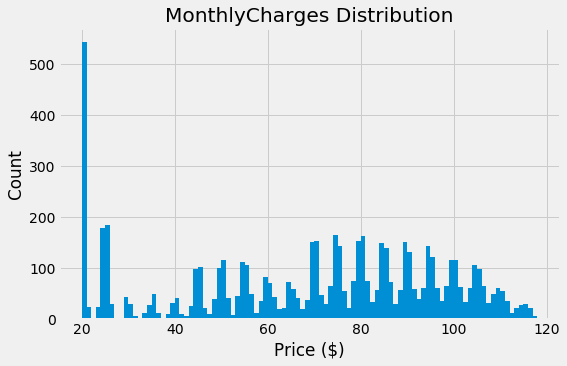

In [184]:
bins = np.arange(20, df['MonthlyCharges'].max(), 1)

plt.figure(figsize=[8, 5])
plt.hist(data=df, x='MonthlyCharges', bins=bins)

plt.xlabel('Price ($)')
plt.ylabel('Count')

plt.title('MonthlyCharges Distribution');

### When providing narrow bins, there is a large spike around 20, and then there are clusters which could indicate prices of certain packages.

In [174]:
df.tenure.describe()

count    7032.000000
mean       32.421786
std        24.545260
min         1.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64

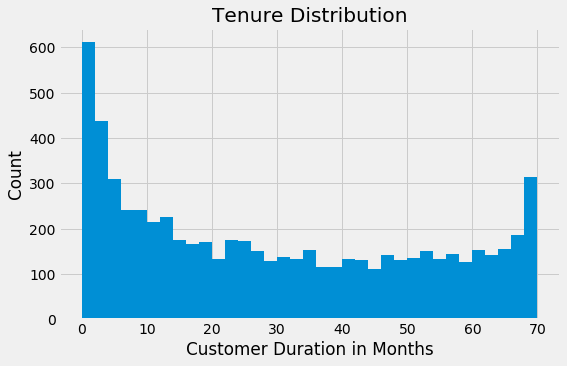

In [181]:
bins = np.arange(0, df['tenure'].max(), 2)

plt.figure(figsize=[8, 5])
plt.hist(data=df, x='tenure', bins=bins)

plt.xlabel('Customer Duration in Months')
plt.ylabel('Count')

plt.title('Tenure Distribution');

### The distribution is fairly flat after the initial new customer peak, and the long time customer tail peak.

In [200]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'], dtype='object')

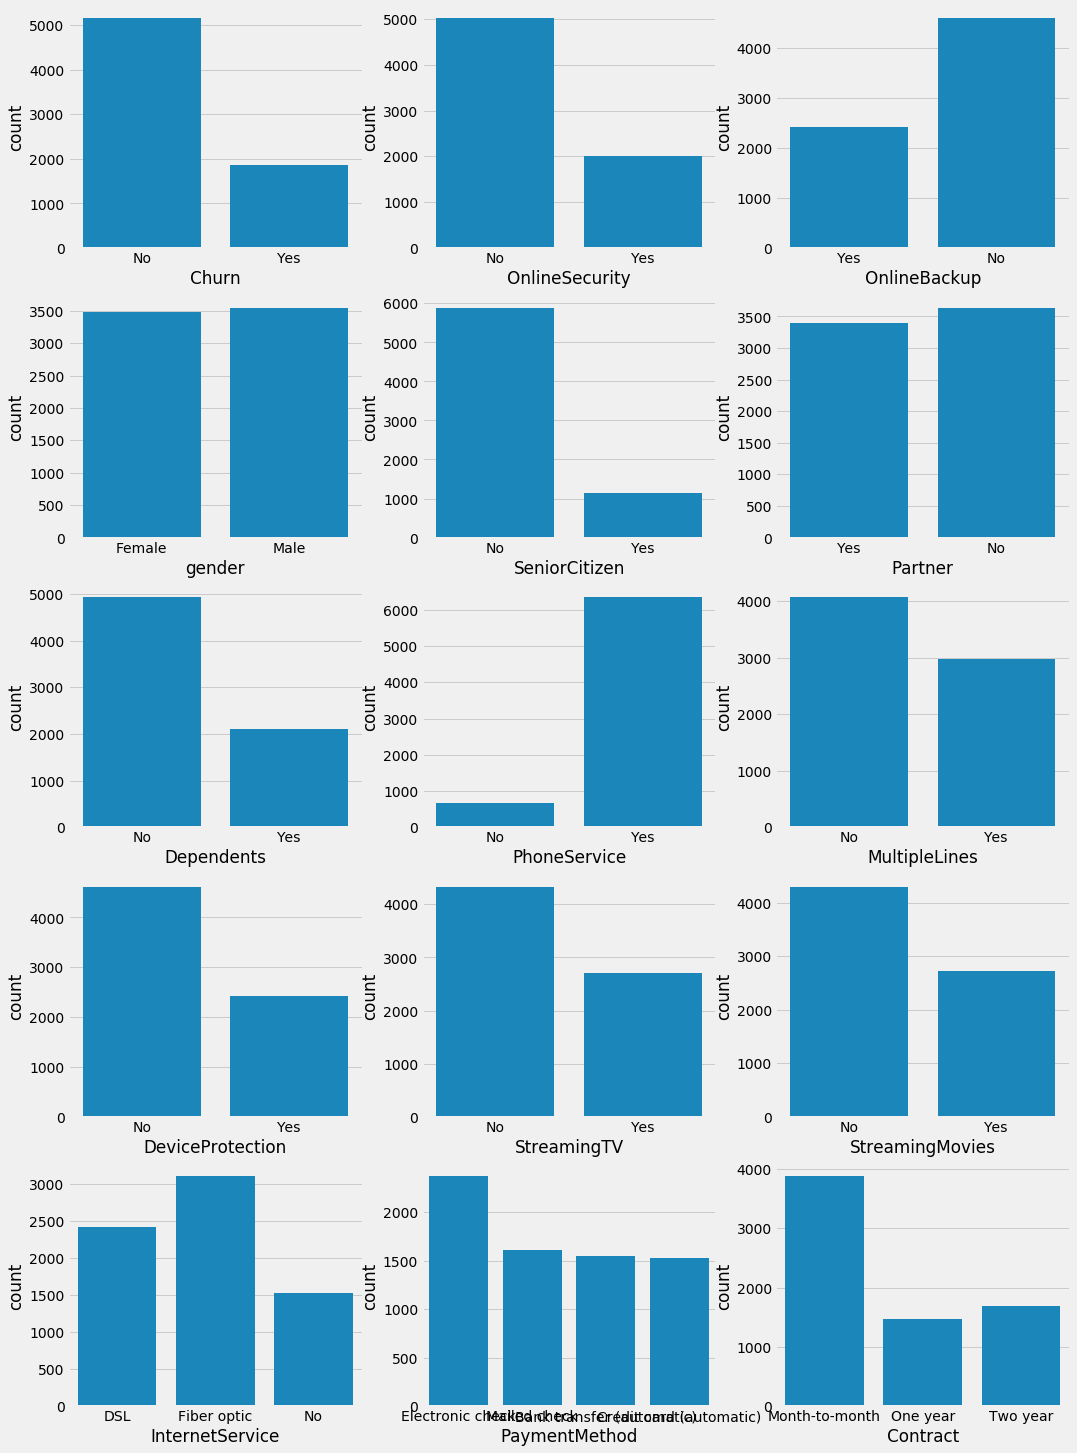

In [214]:
color = sns.color_palette()[0]

fig, ax = plt.subplots(nrows=5, ncols=3, figsize = [16,24])

sns.countplot(data=df, x='Churn', color=color, ax=ax[0,0])
sns.countplot(data=df, x='OnlineSecurity', color=color, ax=ax[0,1])
sns.countplot(data=df, x='OnlineBackup', color=color, ax=ax[0,2])
sns.countplot(data=df, x='gender', color=color, ax=ax[1,0])
sns.countplot(data=df, x='SeniorCitizen', color=color, ax=ax[1,1])
sns.countplot(data=df, x='Partner', color=color, ax=ax[1,2])
sns.countplot(data=df, x='Dependents', color=color, ax=ax[2,0])
sns.countplot(data=df, x='PhoneService', color=color, ax=ax[2,1])
sns.countplot(data=df, x='MultipleLines', color=color, ax=ax[2,2])
sns.countplot(data=df, x='DeviceProtection', color=color, ax=ax[3,0])
sns.countplot(data=df, x='StreamingTV', color=color, ax=ax[3,1])
sns.countplot(data=df, x='StreamingMovies', color=color, ax=ax[3,2])
sns.countplot(data=df, x='InternetService', color=color, ax=ax[4,0])
sns.countplot(data=df, x='PaymentMethod', color=color, ax=ax[4,1])
sns.countplot(data=df, x='Contract', color=color, ax=ax[4,2]);

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> Your answer here!

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> Your answer here!

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Your answer here!

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Your answer here!

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!